In [1]:
from sympy import *
import numpy as np
from scipy.linalg import norm
from itertools import combinations
import pandas as pd

from direct_lingam.ReLVLiNGAM import *
from direct_lingam.simulate_data import *
from direct_lingam.DAG import plot_dag
import pyximport; pyximport.install(inplace=True)

from models import IVModel

Lambda is 
 [[0 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 1 0]]


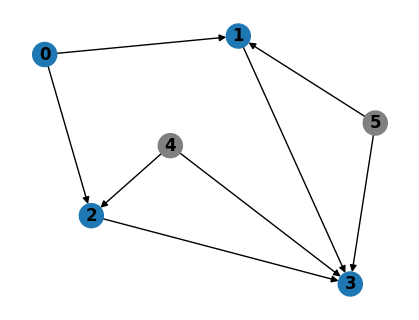

In [2]:
Lambda = get_Lambda([(1,0), (2,0), (3, 1), (3, 2)], 4)
print(f"Lambda is \n {Lambda}")
Gamma = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
highest_l = 1
plot_dag(np.hstack((Lambda, Gamma))) # Latent nodes are grey

In [ ]:
import multiprocess as mp
import time
def run_experiment(seed):

    print(f"Running experiment with seed {seed}")
    noise_distribution = 'gamma'
    samples_sizes = [10**n for n in range(1, 8, 2)]
    n_max = int(max(samples_sizes))

    np.random.seed(seed)
    X, true_B = simulate_data(n_max, noise_distribution=noise_distribution, Lambda=Lambda, Gamma=Gamma, permute_order=False)
    causal_effect_true = [true_B[3, 1], true_B[3, 2]]

    # Perform the experiment
    causal_effect_estimates_cumulant_1, causal_effect_estimates_cumulant_2 =  [], []
    causal_effect_estimate_min_norm_1, causal_effect_estimate_min_norm_2 = [], []
    dist_to_line = []

    for n in samples_sizes:
        X_sample = X[:int(n), :]
        X_sample = np.asfortranarray(X_sample)
        X_sample = X_sample - np.mean(X_sample, axis=0)

        iv_model = IVModel(X_sample, highest_l = 1)
        causal_effect_estimate_cumulant, causal_effect_estimate_min_norm = iv_model.estimate_effect()

        causal_effect_estimates_cumulant_1.append(causal_effect_estimate_cumulant[0])
        causal_effect_estimates_cumulant_2.append(causal_effect_estimate_cumulant[1])

        causal_effect_estimate_min_norm_1.append(causal_effect_estimate_min_norm[0])
        causal_effect_estimate_min_norm_2.append(causal_effect_estimate_min_norm[1])

        a = iv_model.regs[1:-1]
        c = iv_model.regs[-1]
        dist_to_line.append((np.dot(causal_effect_true, a) - c)/np.dot(a, a))

    # Create a DataFrame for the current seed
    seed_df = pd.DataFrame({
        'Seed': [seed] * len(samples_sizes),

        'Sample Size': samples_sizes,

        'True Effect 1': [causal_effect_true[0]] * len(samples_sizes),
        'True Effect 2': [causal_effect_true[1]] * len(samples_sizes),

        'Causal Effect Estimate 1 (Cumulant)': causal_effect_estimates_cumulant_1,
        'Causal Effect Estimate 2 (Cumulant)': causal_effect_estimates_cumulant_2,

        'Causal Effect Estimate 1 (Min Norm)': causal_effect_estimate_min_norm_1,
        'Causal Effect Estimate 2 (Min Norm)': causal_effect_estimate_min_norm_2,

        'Distance to Line': dist_to_line,
    })
    return seed_df


def parallel_simulation(reps):
    pool = mp.Pool(mp.cpu_count())

    seeds = range(reps)
    results = pool.map(run_experiment, seeds)

    pool.close()
    return pd.concat(results, ignore_index=True)

results_df = parallel_simulation(100)

def add_grica_exp(results_df):

    samples_sizes = results_df['Sample Size'].unique()
    n_max = int(max(samples_sizes))
    noise_distribution = 'gamma'

    causal_effect_grica_1, causal_effect_grica_2  = [], []
    for seed in results_df['Seed'].unique():

        np.random.seed(seed)
        X, _ = simulate_data(n_max, noise_distribution=noise_distribution, Lambda=Lambda, Gamma=Gamma, permute_order=False)
        print("GRICA with seed = ", seed)
        time_start = time.time()

        for n in samples_sizes:
            X_sample = X[:int(n), :]
            X_sample = np.asfortranarray(X_sample)
            X_sample = X_sample - np.mean(X_sample, axis=0)

            model = IVModel(X_sample, highest_l=highest_l)
            if n <= 10**5:
                grica_effect = model.estimate_effect_grica()

            causal_effect_grica_1.append(grica_effect[0].item())
            causal_effect_grica_2.append(grica_effect[1].item())
        print("Time taken: ", time.time()-time_start)

    results_df['GRICA Effect Estimate 1'] = causal_effect_grica_1
    results_df['GRICA Effect Estimate 2'] = causal_effect_grica_2
    return results_df

results_df = add_grica_exp(results_df)

In [85]:
results_df.to_csv('Data/iv_with_2_treatments.csv', index=False)

In [3]:
results_df = pd.read_csv('Data/iv_with_2_treatments.csv')

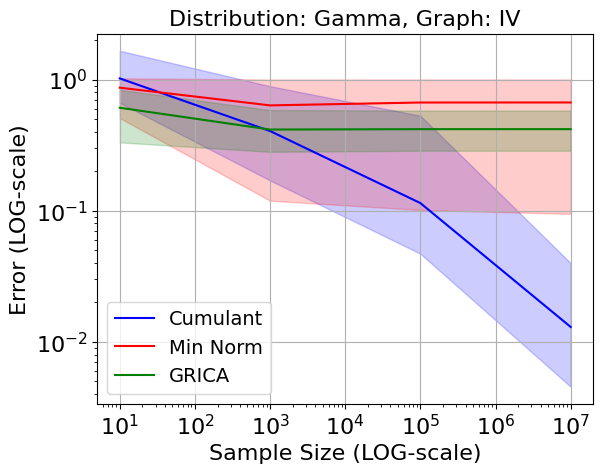

In [10]:
import matplotlib.pyplot as plt

results_df["Cumulant Error 1"] = np.abs((results_df['Causal Effect Estimate 1 (Cumulant)'] - results_df["True Effect 1"])/results_df["True Effect 1"])  # Calculate the error
results_df["Cumulant Error 2"] = np.abs((results_df['Causal Effect Estimate 2 (Cumulant)'] - results_df["True Effect 2"])/results_df["True Effect 2"])  # Calculate the error
results_df["Cumulant Error"] = np.mean([results_df["Cumulant Error 1"], results_df["Cumulant Error 2"]], axis=0)

results_df["Min Norm Error 1"] = np.abs((results_df['Causal Effect Estimate 1 (Min Norm)'] - results_df["True Effect 1"])/results_df["True Effect 1"])  # Calculate the error
results_df["Min Norm Error 2"] = np.abs((results_df['Causal Effect Estimate 2 (Min Norm)'] - results_df["True Effect 2"])/results_df["True Effect 2"])  # Calculate the error
results_df["Min Norm Error"] = np.mean([results_df["Min Norm Error 1"], results_df["Min Norm Error 2"]], axis=0)

results_df["GRICA Error 1"] = np.abs((results_df['GRICA Effect Estimate 1'] - results_df["True Effect 1"])/results_df["True Effect 1"])  # Calculate the error
results_df["GRICA Error 2"] = np.abs((results_df['GRICA Effect Estimate 2'] - results_df["True Effect 2"])/results_df["True Effect 2"])  # Calculate the error
results_df["GRICA Error"] = np.mean([results_df["GRICA Error 1"], results_df["GRICA Error 2"]], axis=0)


# Group the results by sample size and calculate the mean
median_results = results_df.groupby('Sample Size').median()
quantile_results = results_df.groupby('Sample Size').quantile(0.25)
quantile_results2 = results_df.groupby('Sample Size').quantile(0.75)

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# Plot the results

# Plot the mean results
plt.yscale('log')
plt.xscale('log')
plt.plot(median_results.index, median_results["Cumulant Error"],
         label='Cumulant',
         color = "blue")

plt.fill_between(median_results.index, quantile_results["Cumulant Error"], quantile_results2["Cumulant Error"], alpha=0.2, color = "blue")

plt.plot(median_results.index, median_results["Min Norm Error"],
            label='Min Norm',
            color = "red")

plt.fill_between(median_results.index, quantile_results["Min Norm Error"], quantile_results2["Min Norm Error"], alpha=0.2, color = "red")

plt.plot(median_results.index, median_results["GRICA Error"],
            label='GRICA',
            color = "green")

plt.fill_between(median_results.index, quantile_results["GRICA Error"], quantile_results2["GRICA Error"], alpha=0.2, color = "green")


plt.xlabel('Sample Size (LOG-scale)')
plt.ylabel('Error (LOG-scale)')
plt.title(f"Distribution: Gamma, Graph: IV")
plt.legend()
plt.legend(loc="lower left")
plt.grid()
plt.savefig("Figures/gamma_iv_samples_vs_err.png", bbox_inches="tight")
plt.show()

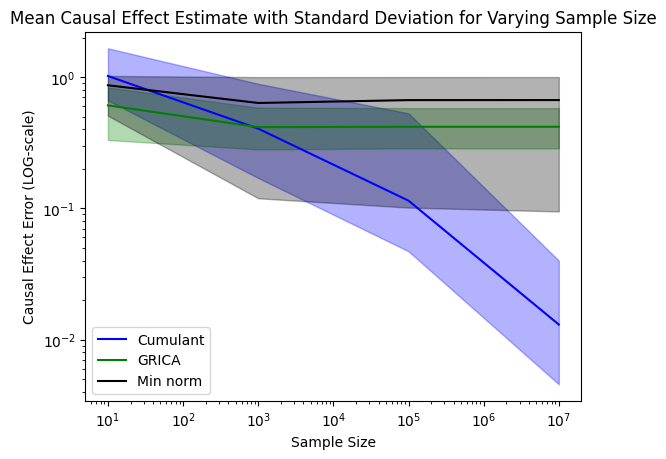

In [ ]:
import matplotlib.pyplot as plt

results_df["Cumulant Error 1"] = np.abs((results_df['Causal Effect Estimate 1 (Cumulant)'] - results_df["True Effect 1"])/results_df["True Effect 1"])  # Calculate the error
results_df["Cumulant Error 2"] = np.abs((results_df['Causal Effect Estimate 2 (Cumulant)'] - results_df["True Effect 2"])/results_df["True Effect 2"])  # Calculate the error
results_df["Cumulant Error"] = np.mean([results_df["Cumulant Error 1"], results_df["Cumulant Error 2"]], axis=0)

results_df["Min Norm Error 1"] = np.abs((results_df['Causal Effect Estimate 1 (Min Norm)'] - results_df["True Effect 1"])/results_df["True Effect 1"])  # Calculate the error
results_df["Min Norm Error 2"] = np.abs((results_df['Causal Effect Estimate 2 (Min Norm)'] - results_df["True Effect 2"])/results_df["True Effect 2"])  # Calculate the error
results_df["Min Norm Error"] = np.mean([results_df["Min Norm Error 1"], results_df["Min Norm Error 2"]], axis=0)

results_df["GRICA Error 1"] = np.abs((results_df['GRICA Effect Estimate 1'] - results_df["True Effect 1"])/results_df["True Effect 1"])  # Calculate the error
results_df["GRICA Error 2"] = np.abs((results_df['GRICA Effect Estimate 2'] - results_df["True Effect 2"])/results_df["True Effect 2"])  # Calculate the error
results_df["GRICA Error"] = np.mean([results_df["GRICA Error 1"], results_df["GRICA Error 2"]], axis=0)


# # Group the results by sample size and calculate the mean
median_results = results_df.groupby('Sample Size').median()
quantile_25 = results_df.groupby('Sample Size').quantile(0.25)
quantile_75 = results_df.groupby('Sample Size').quantile(0.75)
mean_sd = results_df.groupby('Sample Size').std()

# Plot the mean results
plt.yscale('log')
plt.xscale('log')
plt.plot(median_results.index, median_results["Cumulant Error"],
         label='Cumulant',
         color = "blue")

plt.fill_between(median_results.index, quantile_25["Cumulant Error"], quantile_75["Cumulant Error"], alpha=0.3, color = "blue")


plt.plot(median_results.index, median_results["GRICA Error"],
         label='GRICA',
         color = "green")

plt.fill_between(median_results.index, quantile_25["GRICA Error"], quantile_75["GRICA Error"], alpha=0.3, color = "green")

plt.plot(median_results.index, median_results["Min Norm Error"],
         label='Min norm',
         color = "black")


plt.fill_between(median_results.index, quantile_25["Min Norm Error"], quantile_75["Min Norm Error"], alpha=0.3, color = "black")
# plt.plot(median_results.index, np.abs(median_results["Distance to Line"]),
#          label='Distance to Line',
#          color = "red")

plt.xlabel('Sample Size')
plt.ylabel('Causal Effect Error (LOG-scale)')
plt.legend()
plt.title('Median Causal Effect Estimate Error')
plt.show()